In [1]:
import os
import torch
import torchvision
#import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Look into the data directory
data_dir = './data'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['COVID-19', 'NORMAL', 'Viral Pneumonia']


In [3]:
## data extraction for normalizing

image_size = 256
data_stats = ImageFolder(data_dir+'/train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()
]))

In [4]:
loader_stats = DataLoader(data_stats, batch_size = len(data_stats), num_workers = 3)
data_for_stats = next(iter(loader_stats))

In [5]:
data_for_stats[0].shape

torch.Size([2680, 3, 256, 256])

In [6]:
mn = []
sd = []

for i in range(3):
    mn.append(data_for_stats[0][:,i,:,:].mean())
    sd.append(data_for_stats[0][:,i,:,:].std())

mn,sd

([tensor(0.4883), tensor(0.4885), tensor(0.4887)],
 [tensor(0.2450), tensor(0.2450), tensor(0.2451)])

In [14]:
mn = [0.4883, 0.4885, 0.4887]
sd = [0.2450, 0.2450, 0.2451]

In [15]:
image_size = 128
batch_size = 16
stats = mn, sd

In [16]:
dataset = ImageFolder(data_dir+'/train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

#valid_ds = T.Compose([T.ToTensor(), T.Normalize(*stats)])

data_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [17]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [18]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


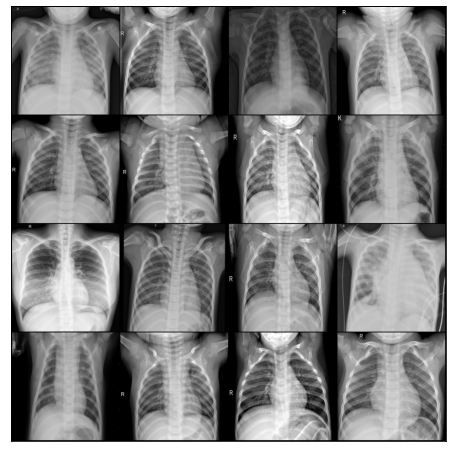

In [11]:
show_batch(data_dl)

In [33]:
len(dataset)

2680

In [19]:
## training and validation datasets

random_seed = 42
torch.manual_seed(random_seed);

In [20]:
val_size = int(0.05*(len(dataset)))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2546, 134)

In [21]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [22]:
## using a GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
## MODEL

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)           # 64*128*128
        self.conv2 = conv_block(64, 128, pool=True)        # 128*64*64
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))                 # 128*64*64
        
        self.conv3 = conv_block(128, 256, pool=True)        # 256*32*32
        self.conv4 = conv_block(256, 512, pool=True)        # 512*16*16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))        # 512*16*16
        
        self.conv5 = conv_block(512, 512, pool=True)        # 512*8*8
        self.conv6 = conv_block(512, 1024, pool=True)        # 1024*4*4
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))        # 1024*4*4
        #self.conv7 = conv_block(1024, 2048, pool=True)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, 512),
                                        nn.BatchNorm1d(512),
                                        nn.ReLU(inplace = True),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        #out = self.conv7(out)
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet(3, 3), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.1017497777938843, 'val_acc': 0.15000000596046448}]

In [19]:
epochs = 10
max_lr = 0.01
grad_clip = 0.001
weight_decay = 1e-7
opt_func = torch.optim.Adam
#history = []

In [20]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 0.4181, val_loss: 4.5956, val_acc: 0.5021
Epoch [1], last_lr: 0.00759, train_loss: 0.4632, val_loss: 1.2425, val_acc: 0.8292
Epoch [2], last_lr: 0.01000, train_loss: 0.5333, val_loss: 1.1996, val_acc: 0.7104
Epoch [3], last_lr: 0.00950, train_loss: 0.3593, val_loss: 1.6576, val_acc: 0.6854
Epoch [4], last_lr: 0.00812, train_loss: 0.3194, val_loss: 0.5434, val_acc: 0.9187
Epoch [5], last_lr: 0.00611, train_loss: 0.2525, val_loss: 0.1469, val_acc: 0.9563
Epoch [6], last_lr: 0.00389, train_loss: 0.1225, val_loss: 0.4103, val_acc: 0.9375
Epoch [7], last_lr: 0.00188, train_loss: 0.0766, val_loss: 0.1600, val_acc: 0.9563
Epoch [8], last_lr: 0.00050, train_loss: 0.0491, val_loss: 0.2195, val_acc: 0.9563
Epoch [9], last_lr: 0.00000, train_loss: 0.0342, val_loss: 0.1770, val_acc: 0.9563
Wall time: 18min 23s


In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

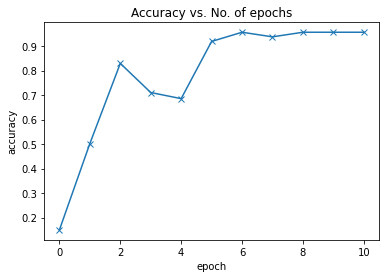

In [22]:
plot_accuracies(history)

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

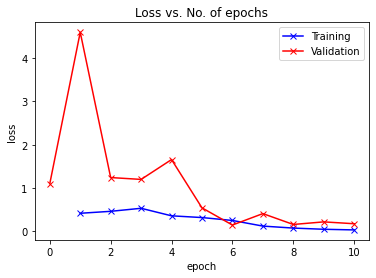

In [24]:
plot_losses(history)

In [25]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

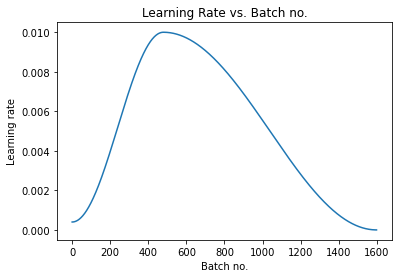

In [26]:
plot_lrs(history)

In [28]:
## saving the model

torch.save(model.state_dict(), 'trained_models/model1.pth')

In [30]:
## loading trained model

model2 = to_device(ResNet(3,3), device)
model2.load_state_dict(torch.load('trained_models/model1.pth'))

<All keys matched successfully>

In [29]:
## testing

In [53]:
testset = ImageFolder(data_dir+'/test', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
    ]))

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
## testing with single image from testset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: COVID-19 , Predicted: COVID-19


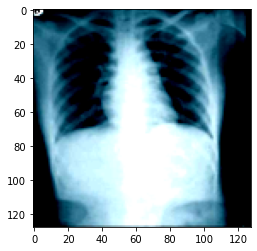

In [66]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model2.eval()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: NORMAL , Predicted: NORMAL


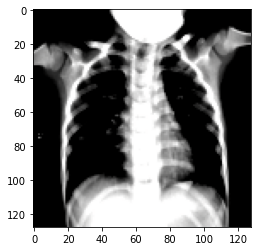

In [67]:
img, label = testset[50]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model2.eval()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Viral Pneumonia , Predicted: Viral Pneumonia


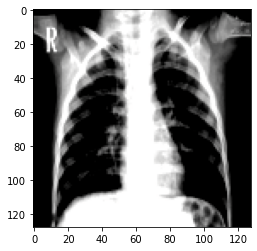

In [68]:
img, label = testset[150]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model2.eval()))

In [ ]:
## testing with whole test set

In [29]:
test_dl = DeviceDataLoader(DataLoader(testset, num_workers=3, pin_memory=True), device)

In [30]:
result = evaluate(model2, test_dl)
result

{'val_loss': 0.21682573854923248, 'val_acc': 0.9644444584846497}

In [ ]:
## testing with image from the web

In [57]:
from PIL import Image
from torch.autograd import Variable

imsize = 128
loader = T.Compose([T.Resize(image_size),
                    T.CenterCrop(image_size),
                    T.ToTensor(),
                    T.Normalize(*stats)
                   ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: COVID-19


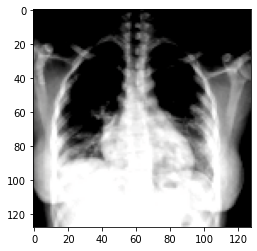

In [58]:
image = image_loader('images/covid1.jpg')

img = Variable(torch.tensor(image))
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model2.eval()))